In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
events_raw = np.loadtxt(path + "data/slider-depth/events.txt")

In [172]:
events_ref = flt.filter_refract(events_raw, 0.05)

In [173]:
start_time = 2.2
duration = 0.2
events_t = flt.filter_time(events_ref, start_time, start_time+duration)

In [174]:
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events = flt.filter_patch(events_t, patch_center, patch_size)

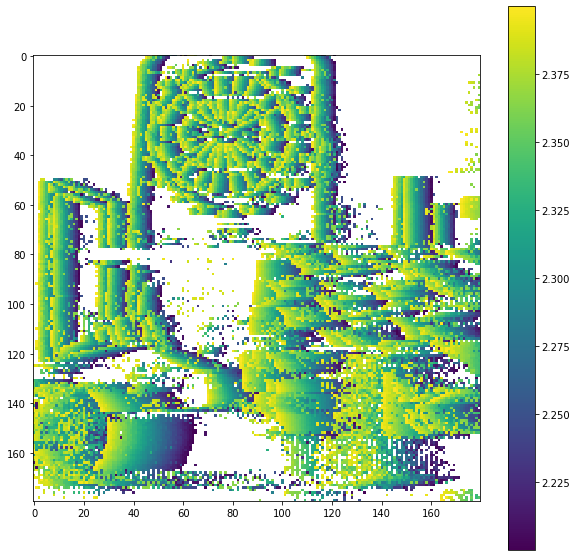

In [175]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

In [224]:
row = 2
last_time = np.full(shape, -1.0)
td_predictions = {}
predictions = {}
px_range_pred = 7
dist = 2
final_td = np.zeros(shape)
for e in events:
#     if e[2] != row:
#         continue
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1]-dist:
        continue
    if last_time[y, x+dist] == -1:
        continue
            
    time_difference = (last_time[y, x] - last_time[y, x+dist]) / dist
    #rint(time_difference)
    
    if (y, x) in td_predictions:
        mean_pred = np.mean(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 0.005:
            last_time[y, x] = -1.0
            continue
        if np.abs(mean_pred - time_difference) > 0.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            continue
        if e[0] > start_time + duration - 0.02 and len(td_predictions[y, x]) > 20:
            final_td[y, x] = mean_pred
        
        td_predictions[y, x] = []
    
    for i in range(1, px_range_pred +1):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            y_p = y + k
            x_p = x - i
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or y_p < 0 or y_p >= shape[0]:
                continue

            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]
    

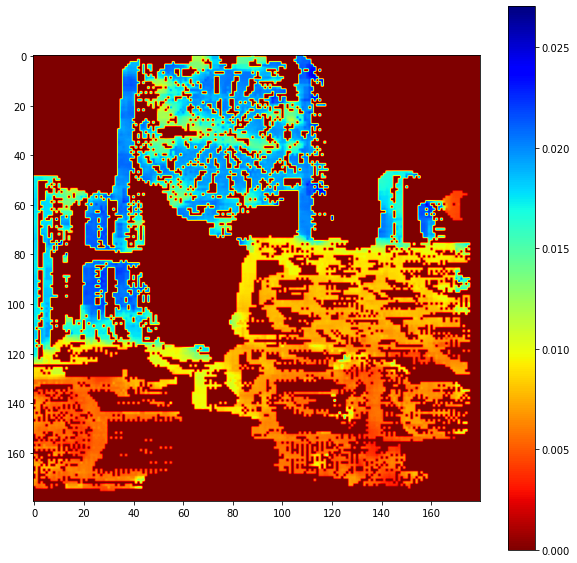

In [225]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 10)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r")
plt.colorbar(m)

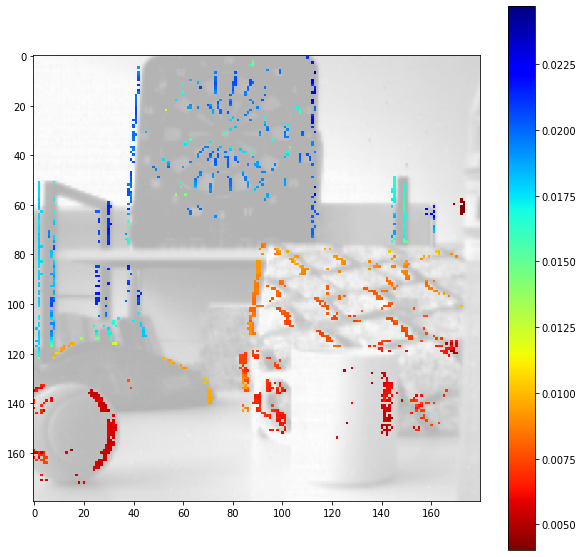

In [226]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + "data/slider-depth/images/frame_00000061.png")
final_td_m = np.ma.masked_where(final_td == 0, final_td)
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(final_td_m, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [227]:
u = np.divide(1.0, final_td, where=final_td!=0.0)

In [230]:
d = td.td2depth_slider(u)

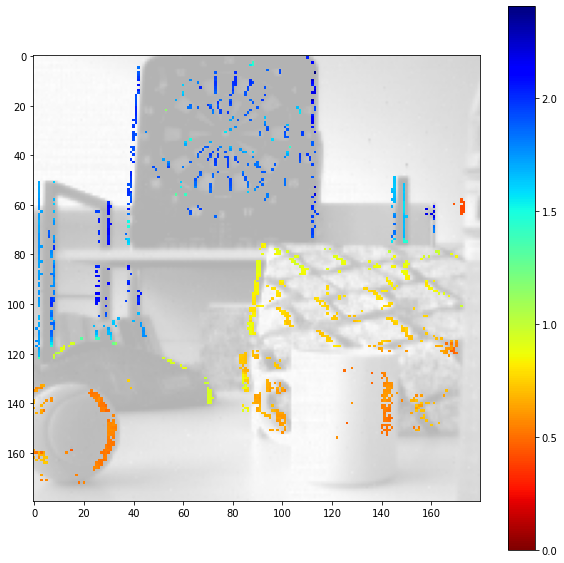

In [231]:
plt.figure(figsize=(10, 10))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none", vmin=0)
plt.colorbar(m)

In [232]:
%matplotlib qt
vis.visualize3d(d)

In [204]:
points = vis._image2pointcloud(d)

In [205]:
calib = np.loadtxt(path + "/data/slider-depth/calib.txt")
gt = np.loadtxt(path + "/data/slider-depth/groundtruth.txt")
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]

In [206]:
proj = td.project3d(points, calib, pose)

In [207]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r", vmin=0.5, vmax=2.5)
ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [208]:
proj = proj[proj[:,2] < 3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3])

In [233]:
o3d.visualization.draw_geometries([pcd])